In [82]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split

In [2]:
mode = 'jupyter' #colab
render = 'plot' #image

In [3]:
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

if mode == 'colab':
    import cufflinks as cf
    cf.go_offline()
    init_notebook_mode(connected=False)

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Config for Colab
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [4]:
if render == 'image':
    import plotly.io as pio
    pio.renderers.default = 'png'

In [5]:
np.random.seed(123)

# Regression Analysis
In this section we will discuss about the assumptions of regression analysis to verify whether regression model can be applied to a specific dataset.

We will look at practical example to understand how to analyze and transform a dataset so that we can apply regression and predict output from a set of independent variables.

## Assumptions of Regression

To apply regression to any specific dataset, we must ensure that the dataset satisifies the condition provided below. If a dataset fails to satisfy some of the conditions, we can transform the data to remedy the problem. However, there are certain scenarios where transformation is not an option and in this case, we will be unable to apply regression to the data e.g. if two variables are not correlated, then there is no point applying regression to the dataset as we will be unable to predict the value of output variable from the values of independent variable.

**1. Linearity**

A linear regression model assumes that the **relationship between the dependent and independent variables is linear**. This can be verified by creating a scatter plot of an independent variable against the dependent variable. 

**Condition**
If the data points form a pattern resembling a straight line, the assumption holds. 

**Solution: Transformation**
If the relationship is non-linear (e.g., a curve), the data must be transformed (e.g., using **logarithmic or exponential transformations**) before applying a linear regression.


**2. No endogeneity**

This assumption states that there should be no correlation between the error terms and the independent variables (the covariance of the error and the Xs is zero). A violation often points to "omitted variable bias," which occurs when a relevant independent variable is left out of the model. This causes the error term to be correlated with the included independent variables, leading to biased and counterintuitive coefficient estimates. 

**If we forget to include an important independent variable which is important to predict the output of the dependent variable, we may face this problem.**

**Condition**
There should be no correlation between the error terms and the independent variables

**Solution: Include missing variables**
The fix is to identify and include the missing variable. When in doubt, it is generally better to include a potentially irrelevant variable than to exclude a relevant one.


**3. Normality and homoscedasticity**

This assumption covers three aspects of the error term:
*   **Normality**: The error term is assumed to be normally distributed. This is crucial for making inferences (e.g., using t-statistics and F-statistics). For large samples, the Central Limit Theorem allows us to assume normality.
*   **Zero Mean**: The error terms should have a mean of zero. The inclusion of an intercept in the regression model typically ensures this condition is met.
*   **Homoscedasticity**: This means the error terms have a constant variance. If the variance changes for different values of the independent variables (a condition called heteroscedasticity), the predictions will be less reliable. This can be detected by looking for patterns in the residuals. 

**Solution: Transformation**
Fixes include checking for omitted variables, removing outliers, or applying transformations like a log transformation to the variables.


**4. No autocorrelation**

Also known as no serial correlation, this assumption means that the error terms are uncorrelated with each other. This is a common issue in time series data where observations have a natural sequence (e.g., stock prices). 

Autocorrelation can be detected by plotting the residuals and looking for patterns or by using the Durbin-Watson test (a value of 2 indicates no autocorrelation). 

**Solution: Use a different model***
If autocorrelation is present, a linear regression is not appropriate, and other models like ARIMA should be used.


**5.No multicollinearity**

This assumption requires that there is no high correlation between two or more independent variables. Perfect multicollinearity occurs when one independent variable is an exact linear combination of another, making it impossible to estimate the coefficients correctly. High (but not perfect) multicollinearity can also distort the results, leading to incorrect estimates and p-values. It can be detected by checking the correlation matrix of the independent variables before running the regression. 

**Solution: Filtering and merging variables**
Fixes include dropping one of the correlated variables or transforming them into a single variable.

In [6]:
# Load the data from a .csv in the same folder
raw_data = pd.read_csv('dataset.csv')
# Let's explore the top 5 rows of the df
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


## Dataset

The dataset contains information about used cars. The goal of this regression analysis will be to predict the price of a used car based on its various features.

The dataset includes the following columns:

- **Brand:** The brand of the car (e.g., BMW, Mercedes-Benz, Audi). This is a categorical variable.

- **Price:** The price of the car in dollars. This will be our dependent variable (the variable we want to predict).

- **Body:** The body type of the car (e.g., sedan, van, crossover). This is a categorical variable.

- **Mileage:** The mileage of the car in miles. This is a numerical variable.

- **EngineV:** The volume of the engine in liters. This is a numerical variable.

- **Engine Type:** The type of engine (e.g., Petrol, Diesel, Gas). This is a categorical variable.

- **Registration:** Whether the car is registered (yes/no). This is a categorical variable.

- **Year:** The year the car was manufactured. This is a numerical variable.

- **Model:** The specific model of the car. This is a categorical variable.

We will use the other columns as independent variables to build a model that predicts the Price.

**Exluded Colums**
- Model

In [7]:
# For these several lessons, we will create the regression without 'Model'
# Certainly, when you work on the problem on your own, you could create a regression with 'Model'
data = raw_data.drop(['Model'],axis=1)

# Let's check the descriptives without 'Model'
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000


### 1.0 Preprocessing

In this section we will discuss how to preprocess the dataset. Some of the approaches to preprocss the data before applying regression are as follows:

### 1.1 Dealing with Missing Values

We can apply different techniques to deal with missing values within the dataset. Some of the approaches are as follows:

- **Removing all rows that contain missing values:** If removing all rows that contain missing values removes negligible amount of data (e.g. < 5\% in our case), we can usually apply this approach and just drop all rows that contain missing values.


- **Replacing the values:** Sometimes, we can replace the missing values with a default values to keep the entire row and just ignore the cell with the missing values e.g. when dealing with numerical data, we may set missing values to zero or any other number that might result in ignoring these missing values during calculation.

In our case, we will remove all rows that contain the missing values since it does not affect much of the dataset.

In [8]:
# Let's simply drop all missing values
# This is not always recommended, however, when we remove less than 5% of the data, it is okay
data_no_mv = data.dropna(axis=0)

### 1.2 Dealing with outliers

A great step in the data exploration is to display the probability distribution function (PDF) of a variable. The PDF will show us how that variable is distributed. This makes it very easy to spot anomalies, such as outliers. The PDF is often the basis on which we decide whether we want to transform a feature.

It is easy to detect outliers within a dataset, if we view the probability distribution of an independent variable. Outliers may bias the dataset and therefore result in wrong prediction. Therefore, it is always recommended to remove outliers before applying regression if the presence of an outlier impacts the dataset heavily. For example, when dealing with house price, if some of the data contains the prices of house from an urban area and rest of them from a rural area, then usually the price of houses from urban area will be considered as an outlier. Since the prices of house in an urban area is considered to be much higher than that of rural area, the presence of such data might bias the model and provide the wrong prediction.

- **Removing outliers that lie above a certain percentile:** We can plot the distribution of a variable. If we see that over 90\% of the sorted data lies within a specific range, and the rest 10\% is very different from that of the 90\%, we can consider that data as outlier and only keep the ones that lie within a certain percentile.

In [15]:
configure_plotly_browser_state()
fig = plt.figure()
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=('Price', 'Mileage', 'EngineV', 'Year'))

fig.add_trace(go.Histogram(x=data_no_mv['Price'], name='Price'), row=1, col=1)
fig.add_trace(go.Histogram(x=data_no_mv['Mileage'], name='Mileage'), row=1, col=2)
fig.add_trace(go.Histogram(x=data_no_mv['EngineV'], name='EngineV'), row=2, col=1)
fig.add_trace(go.Histogram(x=data_no_mv['Year'], name='Year'), row=2, col=2)

fig.update_layout(height=600, showlegend=False, title_text="Distribution of Variables")
fig.show()

<Figure size 640x480 with 0 Axes>

Without diving too deep into the topic, we can deal with the problem easily by removing 0.5%, or 1% of the problematic samples. Here, the outliers are situated around the higher prices (right side of the graph). Logic should also be applied. This is a dataset about used cars, therefore one can imagine how $300,000 is an excessive price. Outliers are a great issue for OLS, thus we must deal with them in some way. It may be a useful exercise to try training a model without removing the outliers.

In [17]:
# Let's declare a variable that will be equal to the 99th percentile of the 'Price' variable i.e. 99% of the 
# data lies below that value
q = data_no_mv['Price'].quantile(0.99)
# Then we can create a new df, with the condition that all prices must be below the 99 percentile of 'Price'
data_no_outliers = data_no_mv[data_no_mv['Price']<q]


q = data_no_outliers['Mileage'].quantile(0.99)
data_no_outliers = data_no_outliers[data_no_outliers['Mileage']<q]

data_no_outliers = data_no_outliers[data_no_outliers['EngineV']<6.5]

q = data_no_outliers['Year'].quantile(0.01)
data_no_outliers = data_no_outliers[data_no_outliers['Year']>q]

data_cleaned = data_no_outliers.reset_index(drop=True)

# In this way we have essentially removed the top 1% of the data about 'Price'
data_cleaned.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3867,3867.000000,3867,3867.000000,3867.000000,3867,3867,3867.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,848,NaN,1467,NaN,NaN,1807,3505,NaN
mean,NaN,18194.455679,NaN,160.542539,2.450440,NaN,NaN,2006.709853
std,NaN,19085.855165,NaN,95.633291,0.949366,NaN,NaN,6.103870
min,NaN,800.000000,NaN,0.000000,0.600000,NaN,NaN,1988.000000
25%,NaN,7200.000000,NaN,91.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11700.000000,NaN,157.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21700.000000,NaN,225.000000,3.000000,NaN,NaN,2012.000000


### 1.3 Checking OLS Assumptions

Before applying a linear regression model to a dataset, we must verify that all conditions of OLS (Ordinary Least Squares) holds. If not, we may need to relax the assumptions and transform the dataset as required to ensure that the conditions of OLS hold and therefore, the dataset can be used for Linear Regression Analysis.

Some of the approaches to verify the OLS assumptions and apply transformation to dataset are provided below.


**Example:**

Let us consider an example. We will build the regression model to predict the price of a car based on its different attributes provided in the dataset.

In this case, 'price' will be the dependent variables and other attributes or features used from the dataset will be considered as independent variable.


#### 1.3.1 Linearity - Verification and transformation

A linear regression model assumes that the **relationship between the dependent and independent variables is linear**. This can be verified by creating a scatter plot of an independent variable against the dependent variable. 

**Condition**
If the data points form a pattern resembling a straight line, the assumption holds. 

**Solution: Transformation**
If the relationship is non-linear (e.g., a curve), the data must be transformed (e.g., using **logarithmic or exponential transformations**) before applying a linear regression.


**Example**

If we consider the relationship between the dependent variable (price) and other independent variables (Year, EngineV, and Mileage), we can see the following relationship:

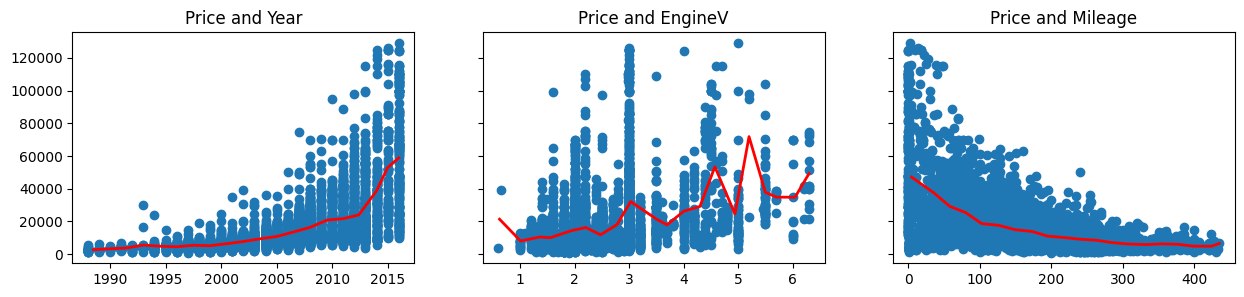

In [23]:
# Here we decided to use some matplotlib code, without explaining it
# You can simply use plt.scatter() for each of them (with your current knowledge)
# But since Price is the 'y' axis of all the plots, it made sense to plot them side-by-side (so we can compare them)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3)) #sharey -> share 'Price' as y
ax1.scatter(data_cleaned['Year'],data_cleaned['Price'])
ax1.set_title('Price and Year')

# Create bins for the 'Year' and calculate the mean 'Price' for each bin
bins = np.linspace(data_cleaned['Year'].min(), data_cleaned['Year'].max(), 20)
binned = data_cleaned.groupby(np.digitize(data_cleaned['Year'], bins))
mean_price = binned['Price'].mean()
mean_year = binned['Year'].mean()

# Plot the binned average curve
ax1.plot(mean_year, mean_price, color='red', linewidth=2)
ax1.set_title('Price and Year')

ax2.scatter(data_cleaned['EngineV'],data_cleaned['Price'])
# Create bins for the 'Year' and calculate the mean 'Price' for each bin
bins = np.linspace(data_cleaned['EngineV'].min(), data_cleaned['EngineV'].max(), 20)
binned = data_cleaned.groupby(np.digitize(data_cleaned['EngineV'], bins))
mean_price = binned['Price'].mean()
mean_engineV = binned['EngineV'].mean()

# Plot the binned average curve
ax2.plot(mean_engineV, mean_price, color='red', linewidth=2)
ax2.set_title('Price and EngineV')


ax3.scatter(data_cleaned['Mileage'],data_cleaned['Price'])
# Create bins for the 'Mileage' and calculate the mean 'Price' for each bin
bins = np.linspace(data_cleaned['Mileage'].min(), data_cleaned['Mileage'].max(), 20)
binned = data_cleaned.groupby(np.digitize(data_cleaned['Mileage'], bins))
mean_price = binned['Price'].mean()
mean_mileage = binned['Mileage'].mean()

# Plot the binned average curve
ax3.plot(mean_mileage, mean_price, color='red', linewidth=2)

ax3.set_title('Price and Mileage')


plt.show()

From the subplots and the PDF of price, we can easily determine that 'Price' is exponentially distributed. A good transformation in that case is a log transformation.

In [24]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=data_cleaned['Price'], name='Price'))
fig.update_layout(title_text="Distribution of Price after removing outliers")
fig.show()

In [25]:
# Let's transform 'Price' with a log transformation
log_price = np.log(data_cleaned['Price'])

# Then we add it to our data frame
data_cleaned['log_price'] = log_price
data_cleaned = data_cleaned.drop(['Price'], axis=1)

fig = go.Figure()
fig.add_trace(go.Histogram(x=data_cleaned['log_price'], name='Log Price'))
fig.update_layout(title_text="Distribution of Log Price after removing outliers")
fig.show()

After applying a logarithmic transformation, we can see that the price is distributed normally and is no longer exponential. Now, if we plot the relationship between the dependent and the indenpendent variables, we can see the following distributions:

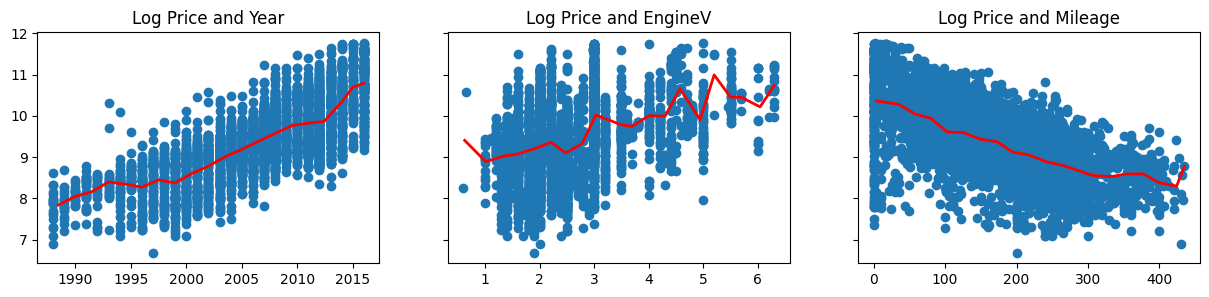

In [26]:
# Here we decided to use some matplotlib code, without explaining it
# You can simply use plt.scatter() for each of them (with your current knowledge)
# But since Price is the 'y' axis of all the plots, it made sense to plot them side-by-side (so we can compare them)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3)) #sharey -> share 'Price' as y
ax1.scatter(data_cleaned['Year'],data_cleaned['log_price'])
ax1.set_title('Log Price and Year')

# Create bins for the 'Year' and calculate the mean 'Price' for each bin
bins = np.linspace(data_cleaned['Year'].min(), data_cleaned['Year'].max(), 20)
binned = data_cleaned.groupby(np.digitize(data_cleaned['Year'], bins))
mean_price = binned['log_price'].mean()
mean_year = binned['Year'].mean()

# Plot the binned average curve
ax1.plot(mean_year, mean_price, color='red', linewidth=2)
ax1.set_title('Log Price and Year')

ax2.scatter(data_cleaned['EngineV'],data_cleaned['log_price'])
# Create bins for the 'Year' and calculate the mean 'Price' for each bin
bins = np.linspace(data_cleaned['EngineV'].min(), data_cleaned['EngineV'].max(), 20)
binned = data_cleaned.groupby(np.digitize(data_cleaned['EngineV'], bins))
mean_price = binned['log_price'].mean()
mean_engineV = binned['EngineV'].mean()

# Plot the binned average curve
ax2.plot(mean_engineV, mean_price, color='red', linewidth=2)
ax2.set_title('Log Price and EngineV')


ax3.scatter(data_cleaned['Mileage'],data_cleaned['log_price'])
# Create bins for the 'Mileage' and calculate the mean 'Price' for each bin
bins = np.linspace(data_cleaned['Mileage'].min(), data_cleaned['Mileage'].max(), 20)
binned = data_cleaned.groupby(np.digitize(data_cleaned['Mileage'], bins))
mean_price = binned['log_price'].mean()
mean_mileage = binned['Mileage'].mean()

# Plot the binned average curve
ax3.plot(mean_mileage, mean_price, color='red', linewidth=2)

ax3.set_title('Log Price and Mileage')

plt.show()

The dataset in first and third columns have a linear relationship. The data in the second column is almost linear and therefore, we can consider the logarithmic transformation of the dependent variable as a solution to ensure **Linearity** before applying regression.

However, since we have transformed the values of the dependent variable (output variable), the predicitons made by the model will be the logarithmic price of the car based on the input feature vectors. Therefore, we need to transform the prediction back again to its original form to display the correct value of the predicted price.


#### 1.3.2 Multicollinearity - Verification and transformation

This assumption requires that there is no high correlation between two or more independent variables. Perfect multicollinearity occurs when one independent variable is an exact linear combination of another, making it impossible to estimate the coefficients correctly. High (but not perfect) multicollinearity can also distort the results, leading to incorrect estimates and p-values. It can be detected by checking the correlation matrix of the independent variables before running the regression. 

**Solution: Filtering and merging variables**
Fixes include dropping one of the correlated variables or transforming them into a single variable.

**Example**

To ensure that all independent variables within the dataset do not have high correlation within themselves, we can compute the collinearity between the different independent variables. For example, if the model and engine type of a car has high collinearity we can assume that if we discard one of the features e.g. model of the car, we will still get a very accurate output as both the variables provide almost the same information and keeping both of them will be redundant information.

Sklearn does not have a built-in way to check for multicollinearity. one of the main reasons is that this is an issue well covered in statistical frameworks and not in ML ones surely it is an issue nonetheless, thus we will try to deal with it.

We will use, 'Statsmodel' to determine the VIF (variance inflation factor) as this measure is variable specific (not model specific).

***Variance Inflation Factor**

A variance inflation factor (VIF) tells you whether one of your variables is too similar to any others in your model. Researchers and statisticians use VIF to identify potential problems in models, to interpret complex datasets, to validate their findings, and to avoid misleading conclusions. A high VIF can make your model confusing and difficult to interpret, while a low VIF is more stable. 

In [27]:
data_cleaned.columns.values

array(['Brand', 'Body', 'Mileage', 'EngineV', 'Engine Type',
       'Registration', 'Year', 'log_price'], dtype=object)

In our case, we have two types of data: Categorical (Brand, Body, Engine Type, Registration) and Numerical (Mileage, Year, EngineV). 

Since, we have not yet transformed the categorical data, we will compute the VIF of the numerical data and remove the features (colums) that have a high VIF as it provides redundant information to the model.

In [ ]:
variables = data_cleaned[['Mileage','Year','EngineV']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif.head()

,VIF,Features
0,3.791584,Mileage
1,10.354854,Year
2,7.662068,EngineV


1.  **Why 'Year' and 'EngineV' have a high VIF:**
    *   **Year:** The 'Year' variable has the highest VIF (10.36) because it is strongly correlated with 'Mileage'. It's intuitive that newer cars generally have lower mileage, and older cars have higher mileage. This strong relationship means that the information provided by 'Year' is partially redundant when 'Mileage' is already in the model.
    *   **EngineV:** The 'EngineV' (Engine Volume) also has a high VIF (7.66). This suggests a correlation with 'Year' and/or 'Mileage'. For instance, car manufacturing trends change over time; certain periods might favor larger or smaller engines. This creates a correlation between 'Year' and 'EngineV'.

2.  **What the VIF values mean:**
    A VIF value of 1 indicates no correlation among the independent variables. Values between 1 and 5 are generally considered acceptable. A VIF above 5 (and especially above 10) suggests high multicollinearity.
    *   **Year (VIF ≈ 10.4):** This is a high value, indicating that the 'Year' variable is highly predictable from 'Mileage' and 'EngineV'. This can inflate the variance of the regression coefficient for 'Year', making it unstable and hard to interpret.
    *   **Mileage (VIF ≈ 7.9) and EngineV (VIF ≈ 7.7):** These values are also high, indicating significant multicollinearity. The coefficients for these variables in the regression model may also be unreliable.

3.  **Why removing 'Year' is a good step:**
    Since 'Year' has the highest VIF, it is the most redundant feature. Removing it is a standard approach to reduce multicollinearity.
    *   **Impact:** By removing 'Year', you eliminate the primary source of the multicollinearity. The strong correlation between 'Year' and 'Mileage' was inflating the VIF for both. Once 'Year' is removed, the VIF for 'Mileage' and 'EngineV' will decrease significantly, as they will no longer be trying to explain the same variance that 'Year' did. This leads to a more stable and interpretable model.

In [30]:
data_cleaned = data_cleaned.drop(['Year'],axis=1)
data_cleaned.head()

,Brand,Body,Mileage,EngineV,Engine Type,Registration,log_price
0,BMW,sedan,277,2.0,Petrol,yes,8.342840
1,Mercedes-Benz,van,427,2.9,Diesel,yes,8.974618
2,Mercedes-Benz,sedan,358,5.0,Gas,yes,9.495519
3,Audi,crossover,240,4.2,Petrol,yes,10.043249
4,Toyota,crossover,120,2.0,Petrol,yes,9.814656


In [31]:
variables = data_cleaned[['Mileage','EngineV']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif.head()

,VIF,Features
0,2.805214,Mileage
1,2.805214,EngineV


#### 1.3.3 Endogeneity, Autocorrelation, Normality and homoscedasticity

We need to train the model first to test for Endogeneity, Autocorrelation, Normality, and Homoscedasticity. These four assumptions are about the properties of the model's *error terms* (residuals), which are the differences between the predicted and actual values.

Here's a breakdown:

*   **Endogeneity**: This is the assumption that the error terms are not correlated with the independent variables. You can only check this after you have calculated the error terms from your trained model.

*   **Autocorrelation**: This assumption states that the error terms are not correlated with each other. To test this (e.g., with a Durbin-Watson test or by plotting residuals), you first need to generate the residuals by fitting the model.

*   **Normality**: This assumption applies to the distribution of the error terms, not the variables themselves. You must first run the regression to get the residuals and then check if they are normally distributed using a histogram or a Q-Q plot.

*   **Homoscedasticity**: This means the error terms have a constant variance. You test this by plotting the residuals against the predicted values. If you see a pattern (like a cone shape), the assumption is violated. This plot can only be created after the model has made predictions and the residuals are calculated.

Therefore, we will ensure that the assumptions are met, once we complete training the Linear Regression Model with our dataset.

### 1.4 Dealing with Categorical Data

When dealing with categorical data (e.g. brand name of car, type of engine, etc.) we need to transform the values of the variable to a numerical format so that we can include it in our computation. We can follow different approaches to convert the categorical data to a numerical data. Some of them are discussed below:

- **Assigning integer labels to each category:** If we have 10 different values for a specific category or feature we can map the values to a number between 0-9 inclusive. We can then use the numerical value in our calculation and use the mapping to map the values when performing predictions. **These mapped values are known as dummy variables**.
 
- **Creating Dummy Variables:** If a specific independent variable has more than one type of categorical data e.g. if the 'Brand' variable has two categories - 'BMW' and 'Toyota', we will remove the 'brand' variable from the dataset and create two new independent variables 'Brand_BMW' and 'Brand_Toyota'. We will then assign a value of either 0 or 1 for each row in the dataset to these new variables. Therefore, if a row contains the information of a Toyota, the value in the column 'Brand_Toyota' will be set to '1' and the value in the other one will be set to '0'.


#### 1.4.1 Approach 1 - Assigning Dummy Variables
In our case, we will use dummy variables to convert our categorical data to numerical data.


In [32]:
data_with_dummies = pd.get_dummies(data_cleaned, drop_first=True)
data_with_dummies.head()

,Mileage,EngineV,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,277,2.0,8.342840,True,False,False,False,False,False,False,False,True,False,False,False,False,True,True
1,427,2.9,8.974618,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True
2,358,5.0,9.495519,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True
3,240,4.2,10.043249,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
4,120,2.0,9.814656,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True


We can observe that each brand of the car is now placed within a different column and the value of each row is either 'true' or 'false'. In this approach, rather than assigning a label to each category, we have converted each 'brand' type to a different feature vector (column) and assigned a binary value to each row (whether the car belongs to that brand or not).

In this approach, the number of feature vectors or independent variables in our dataset has increased and most of the values within this dummy variables will be set to '0' since a car can only belong to one brand.

In [34]:
print(data_with_dummies.columns.values)

['Mileage' 'EngineV' 'log_price' 'Brand_BMW' 'Brand_Mercedes-Benz'
 'Brand_Mitsubishi' 'Brand_Renault' 'Brand_Toyota' 'Brand_Volkswagen'
 'Body_hatch' 'Body_other' 'Body_sedan' 'Body_vagon' 'Body_van'
 'Engine Type_Gas' 'Engine Type_Other' 'Engine Type_Petrol'
 'Registration_yes']


Similarly, the differnt types of 'Body' and 'Engine Type' are also converted to its own independent variable and assigned a binary value.

**Checking VIF of the categorical data**

Now, since we have transformed our categorical data to numerical data, we can compute the VIF again to determine the set of redundant variables and ignore them if required.

In [57]:
variables = data_with_dummies.copy()
variables = variables.drop(['log_price'], axis=1)
for column in variables.columns:
    if type(variables[column][0]) == np.bool_:
        variables[column] = variables[column].astype(float)
vif_dv = pd.DataFrame()
vif_dv["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif_dv["Features"] = variables.columns
vif_dv.sort_values(by="VIF", ascending=False).head(30)

,VIF,Features
16,9.641446,Registration_yes
1,7.841729,EngineV
0,4.459662,Mileage
10,3.120431,Body_sedan
3,2.868649,Brand_Mercedes-Benz
7,2.844515,Brand_Volkswagen
15,2.498172,Engine Type_Petrol
12,2.470096,Body_van
2,2.294007,Brand_BMW
6,2.162166,Brand_Toyota


From the output provided above, we can see that:

Based on the VIF calculation performed after creating dummy variables, here are the explanations:

1.  **Why VIFs are high and the intuition behind it:**
    *   **`EngineV`:** The VIF for `EngineV` likely increased because the newly added dummy variables for `Engine Type` (e.g., `Engine Type_Diesel`, `Engine Type_Petrol`) are correlated with it. For instance, diesel engines often have different typical engine volumes compared to petrol engines. This overlap in information between `EngineV` and the `Engine Type` dummies creates multicollinearity.

    *   **`Registration_yes`:** This variable's VIF might be high if registration status is correlated with other features like `Mileage` or `Brand`. For example, cars with very high mileage might be less likely to have a current registration, or certain brands might be more commonly sold with registration.


#### 1.4.2 Approach 2 - Assigning Labels

In this approach we will assign labels to different categories of different variables, and then compute the VIF to check the diffrerence between implementing the two approaches.

In [56]:
data_with_labels = data_cleaned.copy()

label_encoder = LabelEncoder()

mappings = {}
for column in data_with_labels.columns:
    if data_with_labels[column].dtype == 'object' or data_with_labels[column].dtype == 'bool':
        data_with_labels[column] = label_encoder.fit_transform(data_with_labels[column])
        mappings[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

data_with_labels.head()

,Brand,Body,Mileage,EngineV,Engine Type,Registration,log_price
0,1,3,277,2.0,3,1,8.342840
1,2,5,427,2.9,0,1,8.974618
2,2,3,358,5.0,1,1,9.495519
3,0,0,240,4.2,3,1,10.043249
4,5,0,120,2.0,3,1,9.814656


We have converted all the categorial variables in our dataset to numerical variables and assigned a label for each value of the variable. We have created a mapping to store the actual values and map them back when required.

Now we will compute the VIF of the dataset and compare it with the 'dummy variable' based approach.

In [59]:
variables = data_with_labels.copy()
variables = variables.drop(['log_price'], axis=1)

vif_lv = pd.DataFrame()
vif_lv["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif_lv["Features"] = variables.columns
vif_lv.sort_values(by="VIF", ascending=False).head(30)

,VIF,Features
5,8.439898,Registration
3,6.067103,EngineV
2,4.003120,Mileage
1,3.699106,Body
0,3.306429,Brand
4,1.934205,Engine Type


In [61]:
vif_dv.sort_values(by="VIF", ascending=False).head(30)

,VIF,Features
16,9.641446,Registration_yes
1,7.841729,EngineV
0,4.459662,Mileage
10,3.120431,Body_sedan
3,2.868649,Brand_Mercedes-Benz
7,2.844515,Brand_Volkswagen
15,2.498172,Engine Type_Petrol
12,2.470096,Body_van
2,2.294007,Brand_BMW
6,2.162166,Brand_Toyota


We can see from the above example, that VIF for different variables is lower when we use the 'label' based approach rather than 'dummy variables' based approach.

Therefore, we will use the label based approach for the transformation of categorical data in our dataset.

In [62]:
data_preprocessed = data_with_labels.copy()
data_preprocessed.head()

,Brand,Body,Mileage,EngineV,Engine Type,Registration,log_price
0,1,3,277,2.0,3,1,8.342840
1,2,5,427,2.9,0,1,8.974618
2,2,3,358,5.0,1,1,9.495519
3,0,0,240,4.2,3,1,10.043249
4,5,0,120,2.0,3,1,9.814656


### 1.5 Feature Scaling - Standardization

Based on the text provided, here is a short note on standardization and the code to implement it.

### Standardization (Feature Scaling)

**What is it?**
Standardization is the process of transforming numerical data from different scales into a single, common scale. This is crucial when features have different magnitudes (e.g., car mileage in thousands and engine volume in single digits). For example, we can transform the data of a variable within the range '0 to 1' or '-1 to -1' by taking the min, max, and mean of the data.

**Why is it important?**
It prevents variables with larger magnitudes from disproportionately influencing the model. By scaling features, we ensure that the algorithm treats all variables equally, leading to more reliable and interpretable results. It also makes it easier to compare the relative importance of different features. Since, the GPUs are optimized to perform floating point operations, we should standardize our dataset and test the model with standardized data as it often provides a higher accuracy.

**How is it done?**
The standard process involves subtracting the feature's mean from each data point and then dividing by the feature's standard deviation. This transforms the data to have a mean of 0 and a standard deviation of 1.

The formula for standardization is:

$z = \frac{x - \mu}{\sigma}$

Where:
-   `z` is the standardized value (z-score)
-   `x` is the original data point
-   `μ` is the mean of the feature
-   `σ` is the standard deviation of the feature


Some of the approaches to applying standardization is as follows:

1. **Applying variable specific standardization:** Another approach would be to apply standardization to each variable (or column) separately. In this case, we will compute the mean of each column and standardize the data for that column. For example, when each variable represents a different information and a different distribution, we apply standardization to that distribution.

After applying standardization to a data, we need to standardize the test or validation data every time before predicting the output from a Regression model. Therefore, the mean used to standardize the training dataset, should be stored and used to compute the standardized values of the test data. This assumes that the mean is population mean of the data that is standardized.

**StandardScaler calculates the mean and standard deviation for each column independently and then uses those specific values to scale that column.**

In [66]:
# The target(s) (dependent variable) is 'log_price'
targets = data_preprocessed['log_price']
# The inputs are all columns BUT the dependent variable
inputs = data_preprocessed.drop(['log_price'],axis=1)

# Create a scaler object
scaler = StandardScaler()
# Fit the inputs (calculate the mean and standard deviation of the data)
scaler.fit(inputs)

# Scale the features and store them in a new variable (the actual scaling procedure)
inputs_scaled = scaler.transform(inputs)
print(inputs_scaled.shape)
print(inputs_scaled[0:5, :])

(3867, 6)
[[-1.05086011  0.26033348  1.2179077  -0.47452478  1.26339752  0.32137366]
 [-0.57159651  1.46669606  2.78660201  0.47359854 -0.93862692  0.32137366]
 [-0.57159651  0.26033348  2.06500263  2.68588629 -0.20461877  0.32137366]
 [-1.53012371 -1.54921039  0.83096311  1.84311     1.26339752  0.32137366]
 [ 0.86619428 -1.54921039 -0.42399234 -0.47452478  1.26339752  0.32137366]]


In the above dataset, we have around 3000 rows and each row has 6 different features where each feature represents the information from a specific column in our dataset.

### 2. Training and Testing

In this section, we will perform the following tasks:

- Split our dataset into three categories: Train, Test, and Validation Data

- Train our regression model using the training dataset

- Compute the Adjusted $R^2$ using the test data.

- Apply feature selection by computing the p-value for each feature based on the prediction output of the test data.

- Retrain our model with selected features and test the performance of our model using the validation data.

In [68]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.3, random_state=365)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=365)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("X_val shape: ", X_val.shape)

X_train shape:  (2706, 6)
X_test shape:  (580, 6)
X_val shape:  (581, 6)


In [72]:
# Train the model
reg = LinearRegression()
reg.fit(X_train,y_train)

# Test the model
y_hat = reg.predict(X_train)

print(f"Accuracy (R^2) for the training set: {reg.score(X_train, y_train):.2f}")

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train, y=y_hat, mode='markers', name='Predictions'))
fig.add_trace(go.Scatter(x=y_train, y=y_train, mode='lines', name='Ideal Fit'))
fig.update_layout(title_text="Predicted vs Actual Log Price (Train Set)", xaxis_title="Actual Log Price", yaxis_title="Predicted Log Price")
fig.show()

Accuracy (R^2) for the training set: 0.69


We have trained and tested our Regression model. We have computed the $R^2$ to test the accuracy our model without feature selection. So, the current accuracy is around $70\%$.

In [79]:
# Plot the residuals
fig = go.Figure()
fig.add_trace(go.Histogram(x=y_train - y_hat, name='Residuals'))
fig.update_layout(title_text="Residuals vs Actual Log Price (Train Set)", xaxis_title="Actual Log Price", yaxis_title="Residuals")
fig.show()

In [80]:
# Weights of the model
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,Brand,-0.103507
1,Body,-0.112041
2,Mileage,-0.471757
3,EngineV,0.297673
4,Engine Type,-0.170670
5,Registration,0.311030


From the weights mentioned above, we can observe the following facts:

- **Mileage** of a car has the most impact on determining the price of a car. Sine the value is negative, the price of a car increases if the mileage (distance driven) is lower and vice-versa.

- **Registration:** Registration status of a car is a very important factor in determining the price. Since the value is positive, the price of a car is likely to increase if the car is registered.

- **EngineV:** The volume of the engine is an important factor in determining the price of a car. The price of the car increases as the volume of the engine increases.


Now, we have determined the weights of different independent variables (features) of our model. Finally, we will apply feature selection by computing the p-value and only keep the most important features that are important to predict the price of the car. Next, we will retrain a new model with only the selected features and test its accuracy.

In [87]:
p_values = f_regression(X_train, y_train)[1]
p_values_df = pd.DataFrame(p_values, columns=['P_values'])
p_values_df['Features'] = inputs.columns
p_values_df.sort_values(by='P_values', ascending=True).head(10)

,P_values,Features
2,1.798761e-268,Mileage
5,7.674637e-141,Registration
3,7.551755e-110,EngineV
1,2.527866e-106,Body
0,1.034553e-08,Brand
4,8.290945e-01,Engine Type


In [ ]:
# Only keeping features with p-value < 0.05 since 0.05 is a standard threshold for computing statistical significance
selected_features = p_values_df[p_values_df['P_values']<0.05]['Features'].tolist()
print("Selected features: ", selected_features) 

Selected features:  ['Brand', 'Body', 'Mileage', 'EngineV', 'Registration']


In [89]:
# Computing the dataset with only the selected features
data_selected = data_preprocessed[selected_features + ['log_price']]
data_selected.head()

,Brand,Body,Mileage,EngineV,Registration,log_price
0,1,3,277,2.0,1,8.342840
1,2,5,427,2.9,1,8.974618
2,2,3,358,5.0,1,9.495519
3,0,0,240,4.2,1,10.043249
4,5,0,120,2.0,1,9.814656


In [90]:
# The target(s) (dependent variable) is 'log_price'
targets = data_selected['log_price']
# The inputs are all columns BUT the dependent variable
inputs = data_selected.drop(['log_price'],axis=1)
# Create a scaler object
scaler = StandardScaler()
# Fit the inputs (calculate the mean and standard deviation of the data)
scaler.fit(inputs)

# Scale the features and store them in a new variable (the actual scaling procedure)
inputs_scaled = scaler.transform(inputs)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.3, random_state=365)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("X_val shape: ", X_val.shape)

# Train the model
reg = LinearRegression()
reg.fit(X_train,y_train)

# Test the model
y_hat = reg.predict(X_train)
print(f"Accuracy (R^2) for the training set: {reg.score(X_train, y_train):.2f}")

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train, y=y_hat, mode='markers', name='Predictions'))
fig.add_trace(go.Scatter(x=y_train, y=y_train, mode='lines', name='Ideal Fit'))
fig.update_layout(title_text="Predicted vs Actual Log Price (Train Set)", xaxis_title="Actual Log Price", yaxis_title="Predicted Log Price")
fig.show()

X_train shape:  (2706, 5)
X_test shape:  (1161, 5)
X_val shape:  (581, 6)
Accuracy (R^2) for the training set: 0.65


In [91]:
# Residuals
fig = go.Figure()
fig.add_trace(go.Histogram(x=y_train - y_hat, name='Residuals'))
fig.update_layout(title_text="Residuals vs Actual Log Price (Train Set)", xaxis_title="Actual Log Price", yaxis_title="Residuals")
fig.show()

After keeping only the features that have a p-value below 0.05, we can see that the accuracy of our model has deacresed from $70\%$ to $65\%$. However, the size of the dataset has also decreased from $16,236$ to $13,530$ which is around $16.7\%$.

Therefore, feature selection is very useful when we are dealing with large dataset and large models like Deep Neural Networks.

### References

1. [The Data Science Course: Complete Data Science Bootcamp](https://www.udemy.com/share/101W9c3@oEFxH6jfeF78cKv-RDiIPVbI_iJt7crj25dGEjsiIRt9MbSV8n50dmB7AlanMAikNg==/)

2. [Variance Inflation Factor (VIF): Definition and Formula](https://www.investopedia.com/terms/v/variance-inflation-factor.asp)